In [1]:
# --- IMPORTS ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# --- CONFIG ---
train_files = [
    "parsed_emg/subject_1/trial_12(left).csv",
    "parsed_emg/subject_1/trial_10(left).csv",
    "parsed_emg/subject_1/trial_8(left).csv",
    "parsed_emg/subject_1/trial_6(left).csv",
    "parsed_emg/subject_1/trial_4(left).csv"
]
test_file = "parsed_emg/subject_1/trial_2(left).csv"
label_col = 5
batch_size = 64
learning_rate = 1e-3
epochs = 10
num_classes = 3

# --- LOAD CSV ---
def load_csv_with_time(path):
    df = pd.read_csv(path, skiprows=1)
    time = df.iloc[:, 0].values.reshape(-1, 1)  # absolute time
    emg = df.iloc[:, 1:5].values.astype("float32")
    X = np.concatenate([time, emg], axis=1)  # shape: (N, 5)
    y = df.iloc[:, label_col].values.astype("int32")
    return X, y


Epoch 1/10
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 32s 939us/step - accuracy: 0.6938 - loss: 0.6391 - val_accuracy: 0.7676 - val_loss: 0.4643
Epoch 2/10
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 30s 883us/step - accuracy: 0.7651 - loss: 0.4998 - val_accuracy: 0.7874 - val_loss: 0.4371
Epoch 3/10
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 29s 855us/step - accuracy: 0.7829 - loss: 0.4702 - val_accuracy: 0.7982 - val_loss: 0.4191
Epoch 4/10
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 29s 847us/step - accuracy: 0.7937 - loss: 0.4526 - val_accuracy: 0.8088 - val_loss: 0.4155
Epoch 5/10
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 28s 842us/step - accuracy: 0.7985 - loss: 0.4432 - val_accuracy: 0.8167 - val_loss: 0.4093
Epoch 6/10
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 29s 850us/step - accuracy: 0.8028 - loss: 0.4332 - val_accuracy: 0.8222 - val_loss: 0.3917
Epoch 7/10
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 28s 844us/step - accuracy: 0.8070 - loss: 0.4261 - val_accuracy: 0.8284 - val_loss: 0.3734
Epoch 8/10
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 29s 850us/s

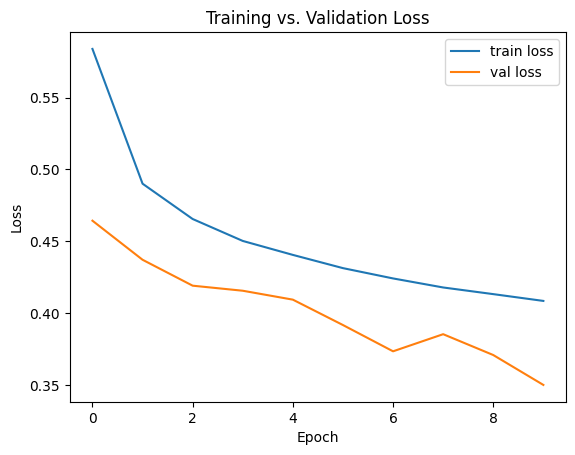

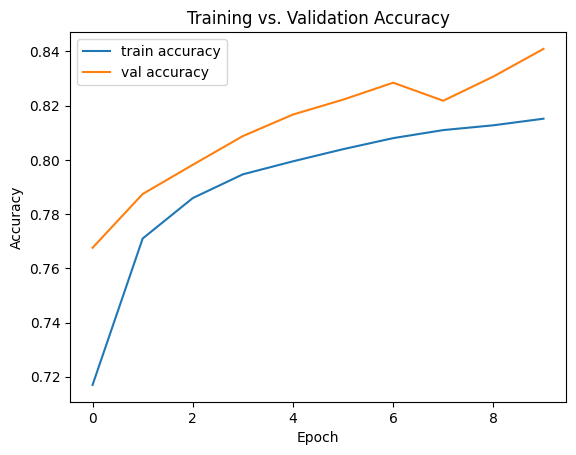

4408/4408 ━━━━━━━━━━━━━━━━━━━━ 2s 429us/step


<Figure size 640x480 with 0 Axes>

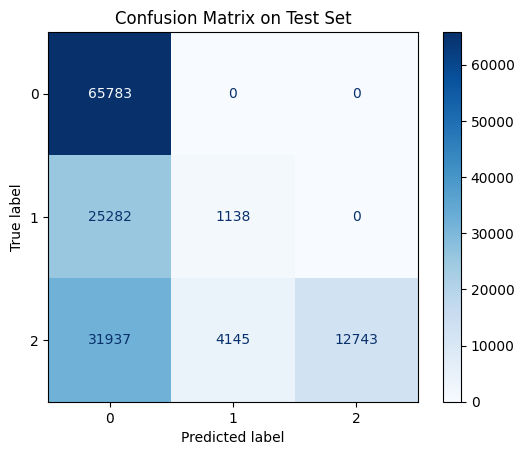

In [3]:
# --- LOAD DATA ---
raw_X_all, raw_y_all = [], []
for f in train_files:
    X, y = load_csv_with_time(f)
    raw_X_all.append(X)
    raw_y_all.append(y)
raw_X_all = np.concatenate(raw_X_all)
raw_y_all = np.concatenate(raw_y_all)

# Normalize (including time)
scaler = MinMaxScaler(feature_range=(0, 1))
raw_X_all = scaler.fit_transform(raw_X_all)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    raw_X_all, raw_y_all, test_size=0.1, random_state=42, stratify=raw_y_all
)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

# Test set
X_test_raw, y_test = load_csv_with_time(test_file)
X_test = scaler.transform(X_test_raw)

# --- CLASS WEIGHTS ---
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

# --- MODEL (fully connected, non-sequential) ---
model = tf.keras.Sequential([
    layers.Input(shape=(5,)),  # 1 time + 4 EMG features
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# --- TRAIN ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weight_dict
)

# --- EVALUATE ---
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest accuracy: {test_acc:.2f}, Test loss: {test_loss:.2f}")

# --- PLOTS ---
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.show()

# Confusion matrix
y_pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred, labels=range(num_classes))
disp = ConfusionMatrixDisplay(cm, display_labels=range(num_classes))
plt.figure()
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix on Test Set')
plt.show()